In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

#### 1. Load the dataset and explore the variables.

In [3]:
data = pd.read_csv('files_for_lab/customer_churn.csv')

In [4]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
data['SeniorCitizen'].value_counts()  #make the column categorical (only 2 values)
data['SeniorCitizen'] = data['SeniorCitizen'].astype('object')

In [7]:
data['tenure'].value_counts()

1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: tenure, Length: 73, dtype: int64

In [8]:
data['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [9]:
data['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [10]:
data['Contract'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

In [11]:
data['TotalCharges'].value_counts() 

          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: TotalCharges, Length: 6531, dtype: int64

In [12]:
def clean_empty_values(col):
    if col in ' ' or '':
        return 0
    else:
        return col
data['TotalCharges'] = list(map(clean_empty_values, data['TotalCharges']))

In [13]:
#turn the values to numeric
data['TotalCharges'] = data['TotalCharges'].astype('float')

In [14]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
TotalCharges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80


#### 2. We will try to predict variable Churn using a logistic regression on variables tenure, SeniorCitizen,MonthlyCharges.
#### 3. Extract the target variable.
#### 4. Extract the independent variables and scale them.

In [15]:
data['Churn'].value_counts()  #target is imbalanced

No     5174
Yes    1869
Name: Churn, dtype: int64

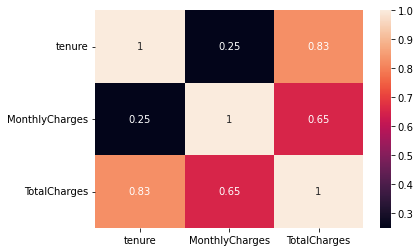

In [16]:
#check te corelation
corr_matrix = data.corr(method = 'pearson')
fig, ax = plt.subplots(figsize = (6, 4))
ax = sns.heatmap(corr_matrix, annot = True)
plt.show()
#because of multicollinearity, don't include 'TotalCharges' to independent variables

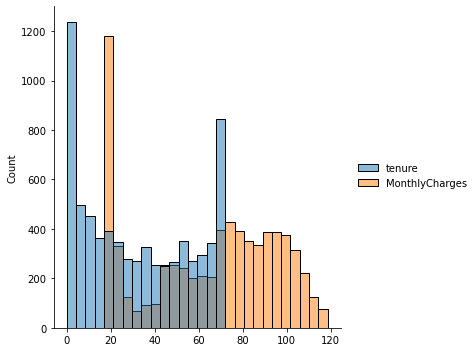

In [17]:
#check the distribution of numerical values
data_num = data[['tenure', 'MonthlyCharges']]
sns.displot(data_num)  
#aren't normally distributed, but it doesn't matter in that case

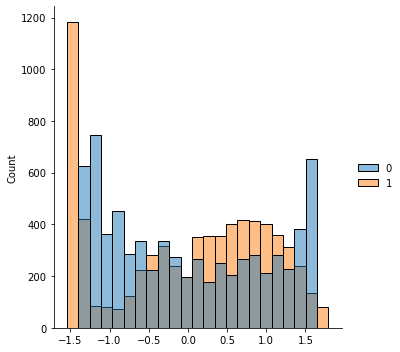

In [18]:
#standardize the data
transformer = StandardScaler().fit(data_num)
x_standardized = transformer.transform(data_num)
x = pd.DataFrame(x_standardized)
sns.displot(x)  

In [60]:
#encode categorical column with dummies
categorical = pd.get_dummies(data['SeniorCitizen'])
categorical

,0,1
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
7038,1,0
7039,1,0
7040,1,0
7041,0,1


#### 5. Build the logistic regression model. 

#### 6. Evaluate the model.

## Prediction - Imbalanced Data 

In [61]:
#set the target
y = data['Churn']
X = np.concatenate((x, categorical), axis = 1) 
#X = tenure, MonthlyCharges, SeniorCitizen

In [62]:
y.value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [83]:
#split the data and predict for trained and tested data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)
classification = LogisticRegression(random_state = 0, solver = 'lbfgs',
                  multi_class = 'ovr').fit(X_train, y_train)
y_train_predict = classification.predict(X_train)
y_test_predict = classification.predict(X_test)

In [84]:
print('Values of train set:')
print(pd.Series(y_train_predict).value_counts())
print('''
Values of test set:''')
print(pd.Series(y_test_predict).value_counts())

Values of train set:
No     4536
Yes    1098
dtype: int64

Values of test set:
No     1146
Yes     263
dtype: int64


The accuracy of the model on train set is: 0.79 
The accuracy of the model on test set is: 0.80 
Confusion matrix on train set:


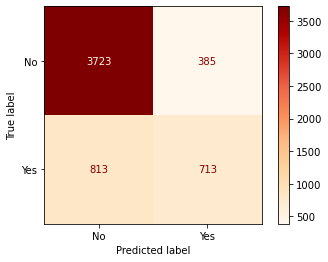

Confusion matrix on test set:


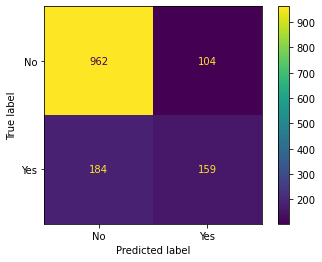

In [86]:
print("The accuracy of the model on train set is: %4.2f " % accuracy_score(y_train, y_train_predict))
print("The accuracy of the model on test set is: %4.2f " % accuracy_score(y_test, y_test_predict))
print('Confusion matrix on train set:')
plot_confusion_matrix(classification, X_train, y_train, cmap='OrRd')
plt.show() 
print('Confusion matrix on test set:')
plot_confusion_matrix(classification, X_test, y_test)
plt.show()

In [41]:
print('Precision scores are (train, test):')
print(round(precision_score(y_train, y_train_predict, pos_label = 'Yes'), 2))
print(round(precision_score(y_test, y_test_predict, pos_label = 'Yes'), 2))
print('Recall scores are (train, test):')
print(round(recall_score(y_train, y_train_predict, pos_label = 'Yes'), 2))
print(round(recall_score(y_test, y_test_predict, pos_label = 'Yes'), 2))
print('F1 scores are (train, test):')
print(round(f1_score(y_train, y_train_predict, pos_label = 'Yes'), 2))
print(round(f1_score(y_test, y_test_predict, pos_label = 'Yes'), 2))

Precision scores are (train, test):
0.65
0.6
Recall scores are (train, test):
0.47
0.46
F1 scores are (train, test):
0.54
0.52


In [31]:
print(classification_report(y_train, y_train_predict))
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

          No       0.82      0.91      0.86      4108
         Yes       0.65      0.47      0.54      1526

    accuracy                           0.79      5634
   macro avg       0.74      0.69      0.70      5634
weighted avg       0.77      0.79      0.78      5634

              precision    recall  f1-score   support

          No       0.84      0.90      0.87      1066
         Yes       0.60      0.46      0.52       343

    accuracy                           0.80      1409
   macro avg       0.72      0.68      0.70      1409
weighted avg       0.78      0.80      0.79      1409



## Prediction - Balanced Data 

### Data Undersampling 

In [43]:
rus = RandomUnderSampler(random_state = 10)
X_rus, Y_rus = rus.fit_resample(X, y)
Y_rus.value_counts()

No     1869
Yes    1869
Name: Churn, dtype: int64

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_rus, Y_rus, test_size = 0.2, random_state = 10)
classification = LogisticRegression(random_state = 0, solver = 'lbfgs',
                  multi_class = 'ovr').fit(X_train, y_train)
y_train_predict = classification.predict(X_train)
y_test_predict = classification.predict(X_test)

In [47]:
print('Values of train set:')
print(pd.Series(y_train_predict).value_counts())
print('''
Values of test set:''')
print(pd.Series(y_test_predict).value_counts())

Values of train set:
Yes    1525
No     1465
dtype: int64

Values of test set:
Yes    387
No     361
dtype: int64


In [46]:
print("The accuracy of the model on train set is: %4.2f " % accuracy_score(y_train, y_train_predict))
print("The accuracy of the model on test set is: %4.2f " % accuracy_score(y_test, y_test_predict))
print('Precision scores are (train, test):')
print(round(precision_score(y_train, y_train_predict, pos_label = 'Yes'), 2))
print(round(precision_score(y_test, y_test_predict, pos_label = 'Yes'), 2))
print('Recall scores are (train, test):')
print(round(recall_score(y_train, y_train_predict, pos_label = 'Yes'), 2))
print(round(recall_score(y_test, y_test_predict, pos_label = 'Yes'), 2))
print('F1 scores are (train, test):')
print(round(f1_score(y_train, y_train_predict, pos_label = 'Yes'), 2))
print(round(f1_score(y_test, y_test_predict, pos_label = 'Yes'), 2))
#now it looks much better

The accuracy of the model on train set is: 0.74 
The accuracy of the model on test set is: 0.72 
Precision scores are (train, test):
0.74
0.68
Recall scores are (train, test):
0.74
0.75
F1 scores are (train, test):
0.74
0.71


### Tomek Links 

In [67]:
t1 = TomekLinks()
X_under, Y_under = t1.fit_resample(X, y)
Y_under.value_counts()

No     4693
Yes    1869
Name: Churn, dtype: int64

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_under, Y_under, test_size = 0.2, random_state = 10)
classification = LogisticRegression(random_state = 0, solver = 'lbfgs',
                  multi_class = 'ovr').fit(X_train, y_train)
y_train_predict = classification.predict(X_train)
y_test_predict = classification.predict(X_test)

In [69]:
print('Values of train set:')
print(pd.Series(y_train_predict).value_counts())
print('''
Values of test set:''')
print(pd.Series(y_test_predict).value_counts())

Values of train set:
No     4106
Yes    1143
dtype: int64

Values of test set:
No     1030
Yes     283
dtype: int64


In [70]:
print("The accuracy of the model on train set is: %4.2f " % accuracy_score(y_train, y_train_predict))
print("The accuracy of the model on test set is: %4.2f " % accuracy_score(y_test, y_test_predict))
print('Precision scores are (train, test):')
print(round(precision_score(y_train, y_train_predict, pos_label = 'Yes'), 2))
print(round(precision_score(y_test, y_test_predict, pos_label = 'Yes'), 2))
print('Recall scores are (train, test):')
print(round(recall_score(y_train, y_train_predict, pos_label = 'Yes'), 2))
print(round(recall_score(y_test, y_test_predict, pos_label = 'Yes'), 2))
print('F1 scores are (train, test):')
print(round(f1_score(y_train, y_train_predict, pos_label = 'Yes'), 2))
print(round(f1_score(y_test, y_test_predict, pos_label = 'Yes'), 2))
#gives low scores

The accuracy of the model on train set is: 0.79 
The accuracy of the model on test set is: 0.80 
Precision scores are (train, test):
0.67
0.71
Recall scores are (train, test):
0.51
0.53
F1 scores are (train, test):
0.58
0.61


### Tomek Links With Oversampling

In [71]:
#try to apply oversampling on Tomek Links
ros = RandomOverSampler(random_state = 10)
X_ros, Y_ros = ros.fit_resample(X_under, Y_under)
Y_ros.value_counts()

No     4693
Yes    4693
Name: Churn, dtype: int64

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, Y_ros, test_size = 0.2, random_state = 10)
classification = LogisticRegression(random_state = 0, solver = 'lbfgs',
                  multi_class = 'ovr').fit(X_train, y_train)
y_train_predict = classification.predict(X_train)
y_test_predict = classification.predict(X_test)

In [77]:
print('Values of train set:')
print(pd.Series(y_train_predict).value_counts())
print('''
Values of test set:''')
print(pd.Series(y_test_predict).value_counts())

Values of train set:
Yes    3766
No     3742
dtype: int64

Values of test set:
No     944
Yes    934
dtype: int64


In [76]:
print("The accuracy of the model on train set is: %4.2f " % accuracy_score(y_train, y_train_predict))
print("The accuracy of the model on test set is: %4.2f " % accuracy_score(y_test, y_test_predict))
print('Precision scores are (train, test):')
print(round(precision_score(y_train, y_train_predict, pos_label = 'Yes'), 2))
print(round(precision_score(y_test, y_test_predict, pos_label = 'Yes'), 2))
print('Recall scores are (train, test):')
print(round(recall_score(y_train, y_train_predict, pos_label = 'Yes'), 2))
print(round(recall_score(y_test, y_test_predict, pos_label = 'Yes'), 2))
print('F1 scores are (train, test):')
print(round(f1_score(y_train, y_train_predict, pos_label = 'Yes'), 2))
print(round(f1_score(y_test, y_test_predict, pos_label = 'Yes'), 2))
#now the scores are even higher than in case of undersampling

The accuracy of the model on train set is: 0.76 
The accuracy of the model on test set is: 0.75 
Precision scores are (train, test):
0.76
0.74
Recall scores are (train, test):
0.76
0.76
F1 scores are (train, test):
0.76
0.75


Confusion matrix on train set:


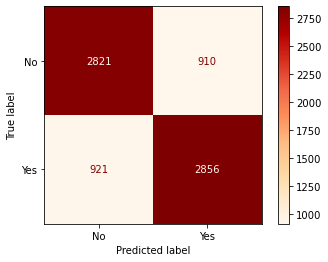

Confusion matrix on test set:


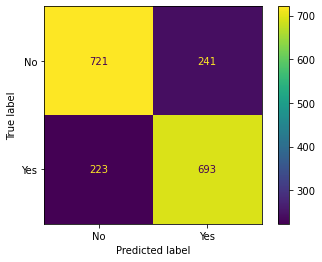

In [81]:
#visualize on matrix
print('Confusion matrix on train set:')
plot_confusion_matrix(classification, X_train, y_train, cmap='OrRd')
plt.show() 
print('Confusion matrix on test set:')
plot_confusion_matrix(classification, X_test, y_test)
plt.show()
#compared to the first prediction there is a visible improvement

### Data Oversampling 

In [53]:
ros = RandomOverSampler(random_state = 10)
X_ros, Y_ros = ros.fit_resample(X, y)
Y_ros.value_counts()

No     5174
Yes    5174
Name: Churn, dtype: int64

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, Y_ros, test_size = 0.2, random_state = 10)
classification = LogisticRegression(random_state = 0, solver = 'lbfgs',
                  multi_class = 'ovr').fit(X_train, y_train)
y_train_predict = classification.predict(X_train)
y_test_predict = classification.predict(X_test)

In [55]:
print('Values of train set:')
print(pd.Series(y_train_predict).value_counts())
print('''
Values of test set:''')
print(pd.Series(y_test_predict).value_counts())

Values of train set:
Yes    4228
No     4050
dtype: int64

Values of test set:
No     1035
Yes    1035
dtype: int64


In [56]:
print("The accuracy of the model on train set is: %4.2f " % accuracy_score(y_train, y_train_predict))
print("The accuracy of the model on test set is: %4.2f " % accuracy_score(y_test, y_test_predict))
print('Precision scores are (train, test):')
print(round(precision_score(y_train, y_train_predict, pos_label = 'Yes'), 2))
print(round(precision_score(y_test, y_test_predict, pos_label = 'Yes'), 2))
print('Recall scores are (train, test):')
print(round(recall_score(y_train, y_train_predict, pos_label = 'Yes'), 2))
print(round(recall_score(y_test, y_test_predict, pos_label = 'Yes'), 2))
print('F1 scores are (train, test):')
print(round(f1_score(y_train, y_train_predict, pos_label = 'Yes'), 2))
print(round(f1_score(y_test, y_test_predict, pos_label = 'Yes'), 2))

The accuracy of the model on train set is: 0.74 
The accuracy of the model on test set is: 0.73 
Precision scores are (train, test):
0.73
0.72
Recall scores are (train, test):
0.75
0.73
F1 scores are (train, test):
0.74
0.72


### SMOTE Oversampling

In [63]:
sm = SMOTE(random_state = 42)
X_sm, Y_sm = sm.fit_resample(X, y)
Y_sm.value_counts()

No     5174
Yes    5174
Name: Churn, dtype: int64

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, Y_sm, test_size = 0.2, random_state = 10)
classification = LogisticRegression(random_state = 0, solver = 'lbfgs',
                  multi_class = 'ovr').fit(X_train, y_train)
y_train_predict = classification.predict(X_train)
y_test_predict = classification.predict(X_test)

In [66]:
print('Values of train set:')
print(pd.Series(y_train_predict).value_counts())
print('''
Values of test set:''')
print(pd.Series(y_test_predict).value_counts())

Values of train set:
Yes    4214
No     4064
dtype: int64

Values of test set:
No     1051
Yes    1019
dtype: int64


In [65]:
print("The accuracy of the model on train set is: %4.2f " % accuracy_score(y_train, y_train_predict))
print("The accuracy of the model on test set is: %4.2f " % accuracy_score(y_test, y_test_predict))
print('Precision scores are (train, test):')
print(round(precision_score(y_train, y_train_predict, pos_label = 'Yes'), 2))
print(round(precision_score(y_test, y_test_predict, pos_label = 'Yes'), 2))
print('Recall scores are (train, test):')
print(round(recall_score(y_train, y_train_predict, pos_label = 'Yes'), 2))
print(round(recall_score(y_test, y_test_predict, pos_label = 'Yes'), 2))
print('F1 scores are (train, test):')
print(round(f1_score(y_train, y_train_predict, pos_label = 'Yes'), 2))
print(round(f1_score(y_test, y_test_predict, pos_label = 'Yes'), 2))

The accuracy of the model on train set is: 0.74 
The accuracy of the model on test set is: 0.72 
Precision scores are (train, test):
0.73
0.71
Recall scores are (train, test):
0.74
0.72
F1 scores are (train, test):
0.74
0.72


#### 7. Even a simple model will give us more than 70% accuracy. Why?


"..in the framework of imbalanced data-sets, accuracy is no longer a proper measure, since it does not distinguish between the numbers of correctly classified examples of different classes."

As accuracy is not the only metrics of prediction, the score doesn't tell us much about the model.
In case with imbalanced data, we see that accuracy score is quite high. However the other metrics (recall, precision and f1) show us that the prediction is not good.

#### 8. Synthetic Minority Oversampling TEchnique (SMOTE) is an over sampling technique based on nearest neighbors that adds new points between existing points. Apply imblearn.over_sampling.SMOTE to the dataset. Build and evaluate the logistic regression model. Is it there any improvement?


There is a noticeable improvement on scores when applying SMOTE oversampling. Despite the fact, that the number of values are the same with RandomOversampler, SMOTE showed scores slightly lower.

#### 9. Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process. Apply imblearn.under_sampling.TomekLinks to the dataset. Build and evaluate the logistic regression model. Is it there any improvement?

After applying Tomek Links, the number of values didn't change so much (compared to other cases). The scores were almost the same with the prediction of imbalanced data. 

I decided to apply RandomOversampler on Tomek Links and got the scores that were the highest among all applied.